Χατζηλίγος Γιώργος 4835 με 2 free passes

In [26]:
# 0. liabriries


import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import coo_matrix, csr_matrix


sns.set()


# 1. load data matrix-data.csv

ratings_df = pd.read_csv("matrix-data.csv", header=None, names=["user_id", "movie_id", "rating"])
#print(ratings_df.head(5))


In [27]:
# 2. PREPROCESSING


# 2.1 Pivot Table   

ratings_matrix = ratings_df.pivot_table(index='movie_id',columns='user_id',values='rating',fill_value=np.nan  )

#print("\npivoted ratings_matrix:", ratings_matrix.shape)
#print(ratings_matrix.head(5))

# 2.2 MATRIX TO CSR

ratings_matrix_sparse = ratings_matrix.astype(pd.SparseDtype("float", np.nan))
ratings_matrix_sparse_filled = ratings_matrix_sparse.fillna(0)
sparse_coo = ratings_matrix_sparse_filled.sparse.to_coo()
X_csr = sparse_coo.tocsr()


Ο K-means αλγοριθμος για k απο 2 εως 16 και με αραιο πινακα.Μετα απο δοκιμες και συμφωνα με το διαγραμμα που βγαζει . Ομαδοποιει καλυτερα απο για 8 εως 10 clusters και κραταω το αποτελεσμα του για Κ = 8 .

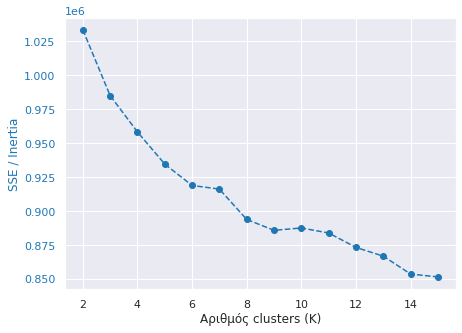

In [28]:
# 3. K-Means Clustering - CSR/SPARSE MATRIX 


k_values = range(2, 16)
inertias = []
sil_scores = []

for k in k_values:
    
    kmeans = KMeans(n_clusters=k, random_state=0, algorithm='lloyd')
    labels = kmeans.fit_predict(X_csr)  

    inertias.append(kmeans.inertia_)
    sil = silhouette_score(X_csr, labels)
    sil_scores.append(sil)


# Plot SSE
fig, ax1 = plt.subplots(figsize=(7,5))
color1 = 'tab:blue'
ax1.set_xlabel('Αριθμός clusters (K)')
ax1.set_ylabel('SSE / Inertia', color=color1)
ax1.plot(k_values, inertias, 'o--', color=color1, label="SSE")
ax1.tick_params(axis='y', labelcolor=color1)

#Ena k gia dokimi#
best_k = 8 
kmeans_final = KMeans(n_clusters=best_k, random_state=0, algorithm='lloyd')
cluster_labels_kmeans = kmeans_final.fit_predict(X_csr)

Ο Agglomerative αλγοριθμος για k απο 2 εως 16 και με πικνο πινακα.Μετα απο δοκιμες και συμφωνα με το διαγραμμα που βγαζει . Ομαδοποιει καλυτερα απο για 10 clusters και κραταω το αποτελεσμα του για Κ = 10 .

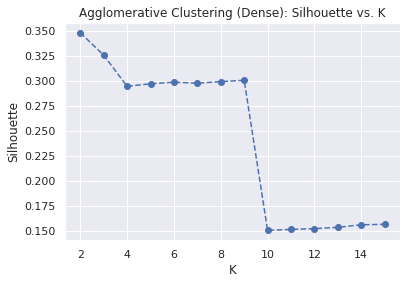

In [29]:
# 4. Agglomerative Clustering - Dense Matrix


X_dense_for_agg = X_csr.toarray()

sil_scores_agg = []
for k in k_values:
    agg = AgglomerativeClustering(n_clusters=k)
    labels_agg = agg.fit_predict(X_dense_for_agg)
    sil = silhouette_score(X_dense_for_agg, labels_agg)
    sil_scores_agg.append(sil)

plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores_agg, 'o--')
plt.title("Agglomerative Clustering (Dense): Silhouette vs. K")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()
#Ena k gia dokimi#
best_k_agg = 10  
agg_final = AgglomerativeClustering(n_clusters=best_k_agg)
cluster_labels_agg = agg_final.fit_predict(X_dense_for_agg)

Ο DBSCAN  αλγοριθμος για eps απο 2 εως 16 και με αραιο πινακα ομαδοποιει καλυτερα για eps = 0.8 δοκιμα για διαφορετικα eps και κραταω το αποτελεσμα του για Κ = 3 .

In [30]:
# 5. DBSCAN CSR/SPARSE MATRIX 

dbscan = DBSCAN(eps=0.8, min_samples=5, metric='euclidean')
cluster_labels_dbscan = dbscan.fit_predict(X_csr)

labels_unique = np.unique(cluster_labels_dbscan)
num_clusters_dbscan = len(labels_unique) - (1 if -1 in labels_unique else 0)
num_outliers = (cluster_labels_dbscan == -1).sum()

print(f"\nDBSCAN (Sparse CSR) {num_clusters_dbscan} clusters and {num_outliers} outliers.")


DBSCAN (Sparse CSR) 3 clusters and 1630 outliers.


Ο DBSCAN  αλγοριθμος για eps απο 2 εως 16 και με αραιο πινακα ομαδοποιει καλυτερα για eps = 0.8 δοκιμα για διαφορετικα eps και κραταω το αποτελεσμα του για Κ = 3 .

In [31]:
# 6. load u.item & genres

u_item = pd.read_csv("u.item",sep='|',header=None,encoding='latin-1')
u_item.columns = [
    "movie_id_original", "title", "release_date", "video_release_date", "imdb_url",
    "unknown", "Action", "Adventure", "Animation", "Children", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
    "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

u_item["movie_id"] = u_item["movie_id_original"] - 1

genre_cols = [
    "unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

u_item_genres = u_item[["movie_id"] + genre_cols].copy()
movies_info = u_item_genres.set_index("movie_id")


In [32]:
# 7. labels pivot

ratings_matrix["cluster_kmeans"] = cluster_labels_kmeans
ratings_matrix["cluster_agg"] = cluster_labels_agg
ratings_matrix["cluster_dbscan"] = cluster_labels_dbscan

#print("\nratings_matrix with cluster labels:")
#print(ratings_matrix.head(5))

In [33]:
# 8. K-means

df_clusters = ratings_matrix[["cluster_kmeans"]].copy()
df_clusters = df_clusters.join(movies_info, how='left')

print("\n=========== K-Means Clusters: Top Genres ===========")
for c in range(best_k):
    cluster_c = df_clusters[df_clusters["cluster_kmeans"] == c]
    total_movies = len(cluster_c)
    
    
    genre_counts = cluster_c[genre_cols].sum().sort_values(ascending=False)
    
    print(f"\n--- Cluster {c} ---")
    print(f"Σύνολο ταινιών: {total_movies}")
    top_genres = genre_counts.head(4)
    print("Top genres:")
    print(top_genres)



=========== K-Means Clusters: Top Genres ===========

--- Cluster 0 ---
Σύνολο ταινιών: 16
Top genres:
Drama       14
Romance      6
Comedy       4
Thriller     1
dtype: int64

--- Cluster 1 ---
Σύνολο ταινιών: 41
Top genres:
Drama       22
Thriller    17
Action      10
Comedy       7
dtype: int64

--- Cluster 2 ---
Σύνολο ταινιών: 1225
Top genres:
Drama       535
Comedy      367
Thriller    159
Romance     156
dtype: int64

--- Cluster 3 ---
Σύνολο ταινιών: 130
Top genres:
Action     46
Comedy     44
Drama      36
Romance    26
dtype: int64

--- Cluster 4 ---
Σύνολο ταινιών: 5
Top genres:
Action       3
Adventure    2
Crime        2
War          2
dtype: int64

--- Cluster 5 ---
Σύνολο ταινιών: 68
Top genres:
Drama       28
Action      21
Comedy      19
Thriller    15
dtype: int64

--- Cluster 6 ---
Σύνολο ταινιών: 53
Top genres:
Comedy      21
Action      21
Thriller    14
Drama       12
dtype: int64

--- Cluster 7 ---
Σύνολο ταινιών: 144
Top genres:
Drama       76
Comedy      42
Ro

In [34]:
# 9. Agglomerative

df_clusters_agg = ratings_matrix[["cluster_agg"]].join(movies_info, how='left')
print("\n=========== Agglomerative Clusters: Top Genres ===========")
for c in range(best_k_agg):
    cluster_c = df_clusters_agg[df_clusters_agg["cluster_agg"] == c]
    total_movies = len(cluster_c)
    
    genre_counts = cluster_c[genre_cols].sum().sort_values(ascending=False)
    print(f"\n--- Cluster {c} ---")
    print(f"Σύνολο ταινιών: {total_movies}")
    print("Top genres:")
    print(genre_counts.head(4))



=========== Agglomerative Clusters: Top Genres ===========

--- Cluster 0 ---
Σύνολο ταινιών: 41
Top genres:
Drama        23
Comedy       13
Romance      12
Adventure     7
dtype: int64

--- Cluster 1 ---
Σύνολο ταινιών: 130
Top genres:
Comedy      51
Action      41
Thriller    35
Drama       33
dtype: int64

--- Cluster 2 ---
Σύνολο ταινιών: 33
Top genres:
Action      15
Drama       13
Thriller    11
Sci-Fi      10
dtype: int64

--- Cluster 3 ---
Σύνολο ταινιών: 59
Top genres:
Drama     27
Comedy    16
War       13
Action    10
dtype: int64

--- Cluster 4 ---
Σύνολο ταινιών: 18
Top genres:
Thriller    11
Drama        8
Action       6
Mystery      4
dtype: int64

--- Cluster 5 ---
Σύνολο ταινιών: 44
Top genres:
Action      17
Children    15
Musical     14
Romance     13
dtype: int64

--- Cluster 6 ---
Σύνολο ταινιών: 150
Top genres:
Drama       69
Comedy      52
Romance     33
Thriller    20
dtype: int64

--- Cluster 7 ---
Σύνολο ταινιών: 310
Top genres:
Drama       121
Comedy       9

In [35]:


# 10. DBSCAN

df_clusters_dbscan = ratings_matrix[["cluster_dbscan"]].join(movies_info, how='left')
print("\n=========== DBSCAN Clusters ================")
labels_dbscan_unique = np.unique(cluster_labels_dbscan)
labels_dbscan_clusters = [lbl for lbl in labels_dbscan_unique if lbl != -1]

for c in labels_dbscan_clusters:
    cluster_c = df_clusters_dbscan[df_clusters_dbscan["cluster_dbscan"] == c]
    total_movies = len(cluster_c)
    genre_counts = cluster_c[genre_cols].sum().sort_values(ascending=False)
    
    print(f"\n--- DBSCAN Cluster {c} ---")
    print(f"Σύνολο ταινιών: {total_movies}")
    print("Top genres:")
    print(genre_counts.head(4))


=========== DBSCAN Clusters ================

--- DBSCAN Cluster 0 ---
Σύνολο ταινιών: 14
Top genres:
Drama          9
Comedy         2
Documentary    2
unknown        1
dtype: int64

--- DBSCAN Cluster 1 ---
Σύνολο ταινιών: 28
Top genres:
Drama       15
Comedy       5
Thriller     3
Romance      3
dtype: int64

--- DBSCAN Cluster 2 ---
Σύνολο ταινιών: 10
Top genres:
Drama          7
Comedy         3
Crime          2
Documentary    2
dtype: int64


Σχολιασμος των αποτελεσματων και των μεθοδων clustering

K-Means: 
Στο διαγραμμα φαινεται να υπαρχει μια σημαντικη μειωση μεταξυ των clusters οταν Κ ειναι 2 - 8 οποτε θα μπορουσαμε να χρησιμοποιησουμε ενα Κ = 8 εως 10 για να παρουμε ενα καλο αποτελεσμα στην ομαδοποιηση των ταινιων  βαση των ratings 


Agglomerative Clustering : 
το διαγραμμα πεφτει αποτομα μεταξυ για Κ = 8-10 οποτε μπορουμε να παρουμε σαν τιμη Κ = 8 εως 10 για να εχουμε μια καλη ομαδοποιηση των ταινιων  

DBSCAN:
ο αλγοριθμος με διαφορετικα eps βρεθηκε να εχει το καλυτερο με eps=0.8 και με αποτελεσμα Κ=3 αρα και 3 clusters 

Οποτε ολα τα αποτελεσματα για clustering ειναι πανω σε αυτες τις τιμες και τα αποτελεσματα τους ειναι τα συγκεκριμενα 